In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!sudo apt install git-lfs
!git lfs version
!rm -rf ml
!mkdir ml
!cd ml
!git init
!git lfs install
!git clone https://github.com/kokoichi206/ml.git
!git fetch
!cd ..
!ls -la ml/akimoto/
!mv ml/akimoto/saka.zip saka.zip
!mv ml/akimoto/akb.zip akb.zip

!rm -rf akb_pre
!rm -rf saka_pre

!ls
!yes | unzip akb.zip > /dev/null
!yes | unzip saka.zip > /dev/null

!ls akb_pre | wc
!ls saka_pre | wc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
git-lfs/2.3.4 (GitHub; linux amd64; go 1.8.3)
Reinitialized existing Git repository in /content/.git/
Updated git hooks.
Git LFS initialized.
Cloning into 'ml'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 79 (delta 19), reused 73 (delta 16), pack-reused 0
Unpacking objects: 100% (79/79), done.
Filtering content: 100% (3/3), 88.76 MiB | 61.83 MiB/s, done.
total 90948
drwxr-xr-x 4 root root     4096 Dec 31 09:26 .
drwxr-xr-x 4 root root     4096 Dec 31 09:26 ..
-rw-r--r-- 1 root root 35182017 Dec 31 09:26 akb.zip
-rw-r--r-- 1 root root     2443 Dec 31 09:26 get_names.py
-rw-r--r-- 1 root root       42 Dec 31 09:26 .gitattributes
-rw-r--r-- 1 root root       26 Dec 31 09:26 .giti

In [ ]:
!ls

akb.zip  ml  saka.zip  sample_data


In [8]:
!ls akb_pre | wc
!ls saka_pre | wc

   3847    3847   42325
   3928    3928   43216


In [9]:
from PIL import Image
import numpy as np
import glob
import gc


groups = ["akb", "saka"]

akbs = glob.glob("akb_pre/*.jpg")
sakas = glob.glob("saka_pre/*.jpg")
faces = []
cnt = 0

print(np.asarray(Image.open(akbs[0]), np.uint8).shape)


for path in akbs:
    cnt += 1
    with Image.open(path) as img:
        # colabでリサイズする場合
        # orig = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

for path in sakas:
    cnt += 1
    with Image.open(path) as img:
        faces.append(np.asarray(img, np.uint8))

X = np.array(faces)
# 正解ラベルを作成する
len_akbs = len(akbs)
len_sakas = len(sakas)
y = np.zeros((len_akbs+len_sakas, 2))
for i in range(len_akbs):
    y[i, 0] = 1
for j in range(len(sakas)):
    y[j+len_akbs, 1] = 1

(128, 128, 3)


In [4]:
print(X.shape)
print(y.shape)
print(X.shape[1])

(9605, 128, 128, 3)
(9605, 2)
128


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [6]:
import tensorflow as tf
import tensorflow.keras.layers as layers

IMG_SIZE = X.shape[1]
inputs = layers.Input((IMG_SIZE,IMG_SIZE,3))
## １層目
x = layers.Conv2D(64, 3, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
## 2層目
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
## 3層目
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)

# ## 4層目
x = layers.Conv2D(512, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(2, activation="softmax")(x)

model = tf.keras.models.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                             

In [19]:
# model.compile("adam", "sparse_categorical_crossentropy", ["sparse_categorical_accuracy"])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 50


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)


# from keras.preprocessing.image import ImageDataGenerator
# generator = ImageDataGenerator(
#            rotation_range=0.2,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
#            shear_range=1,
#            zoom_range=0.2,
#            horizontal_flip=False)
# generator.fit(X_train)

# history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size),
#                               epochs=epochs,
#                               validation_data=(X_test, y_test))


model.save_weights('.models')

Epoch 1/50
53/53 [==============================] - 58s 1s/step - loss: 0.7714 - accuracy: 0.5319 - val_loss: 0.7191 - val_accuracy: 0.5236
Epoch 2/50
53/53 [==============================] - 50s 952ms/step - loss: 0.6747 - accuracy: 0.5761 - val_loss: 0.8132 - val_accuracy: 0.5232
Epoch 3/50
53/53 [==============================] - 50s 951ms/step - loss: 0.6711 - accuracy: 0.5871 - val_loss: 0.7042 - val_accuracy: 0.5236
Epoch 4/50
53/53 [==============================] - 50s 950ms/step - loss: 0.6605 - accuracy: 0.5993 - val_loss: 0.7031 - val_accuracy: 0.5232
Epoch 5/50
53/53 [==============================] - 50s 952ms/step - loss: 0.6644 - accuracy: 0.6027 - val_loss: 0.6983 - val_accuracy: 0.5232
Epoch 6/50
53/53 [==============================] - 50s 950ms/step - loss: 0.6556 - accuracy: 0.6017 - val_loss: 0.7127 - val_accuracy: 0.5243
Epoch 7/50
53/53 [==============================] - 50s 950ms/step - loss: 0.6532 - accuracy: 0.6162 - val_loss: 0.7140 - val_accuracy: 0.5288
Ep

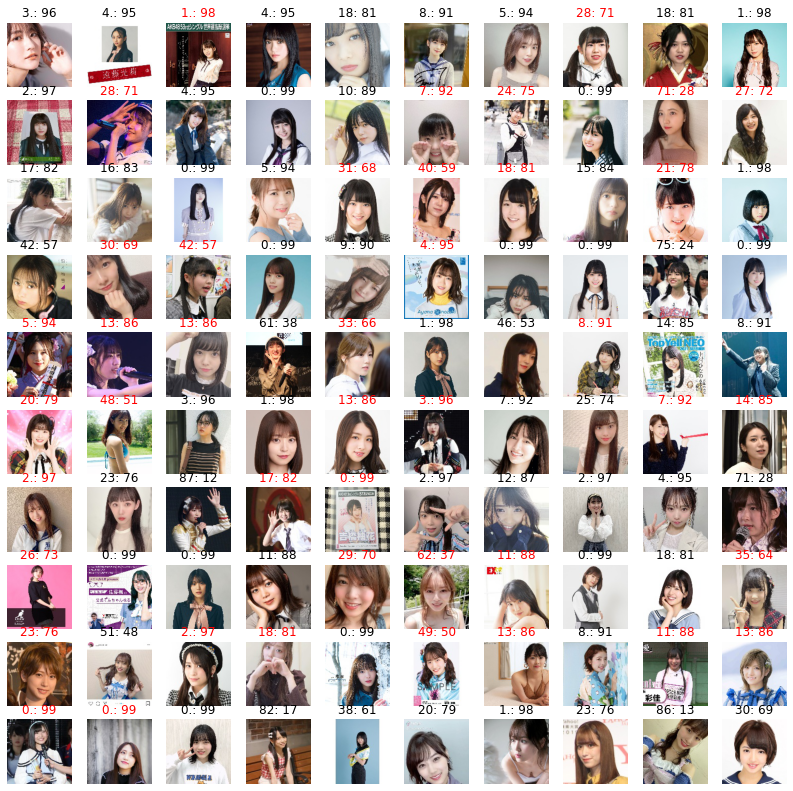

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,14))
y_raw = model.predict(X_test)
y_pred = np.argmax(y_raw, axis=-1) # argmaxでラベルを取る
y_correct = np.argmax(y_test, axis=-1)

for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(X_test[i])
    ax.axis("off")
    # なぜか下のやり方だとうまくいかず
    # akb_percentage = 100*round(y_raw[i][0], 2)
    # saka_percentage = 100*round(y_raw[i][1], 2)
    akb_percentage = str(100*y_raw[i][0])[:2]
    saka_percentage = str(100*y_raw[i][1])[:2]
    if y_pred[i] == y_correct[i]:
        # ax.set_title(groups[y_pred[i]])

        ax.set_title(f"{akb_percentage}: {saka_percentage}")
    else:
        # ax.set_title(groups[y_pred[i]]+" / "+groups[int(y_correct[i])], color="red")

        ax.set_title(f"{akb_percentage}: {saka_percentage}", color="red")


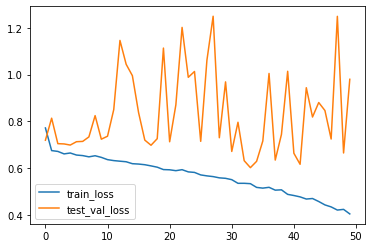

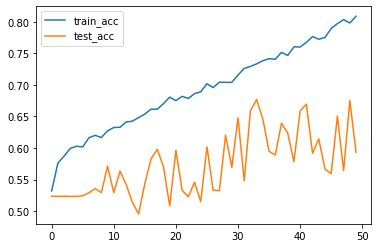

In [21]:
import matplotlib.pyplot as plt

train_loss = history.history['loss'] 
train_acc = history.history['accuracy'] 
val_loss = history.history['val_loss'] 
val_acc = history.history['val_accuracy'] 

plt.plot(np.arange(len(train_loss)), train_loss, label='train_loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='test_val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(np.arange(len(val_acc)), val_acc, label='test_acc')
plt.legend()
plt.show()